# Training Set Generator

## Imports

In [1]:
# Math and Plotting
import numpy as np                         
import matplotlib.pyplot as plt             
from pyscenarios.sobol import sobol  
from scipy import constants, interpolate
%matplotlib inline
import itertools
import math

# Basic Data Imports
import time
from pickle import dump, load    
import pandas as pd

# RDF Analysis and Simulations
import freud
import gsd.hoomd
import hoomd
from utility.hoomd_sim import mie_fluid

# Parallel Computing
import dask
from dask.distributed import Client, progress
from matplotlib.pyplot import figure
from dask import config as cfg

ModuleNotFoundError: No module named 'pyscenarios'

In [2]:
def rdf2sq(r, rdf, Qmin, Qmax, Qnum, ρ):
    q = np.linspace(Qmin, Qmax, Qnum)
    dr = r[1] - r[0] # Stepsize
    sq   = np.zeros(len(q))
    for j in range (len(q)):
        sq[j] = (1 + 4*np.pi*ρ*np.trapz(r*(rdf-1)*np.sin(q[j]*r),dx = dr)/q[j])
    return q, sq

load success
Number of Experiments: 27


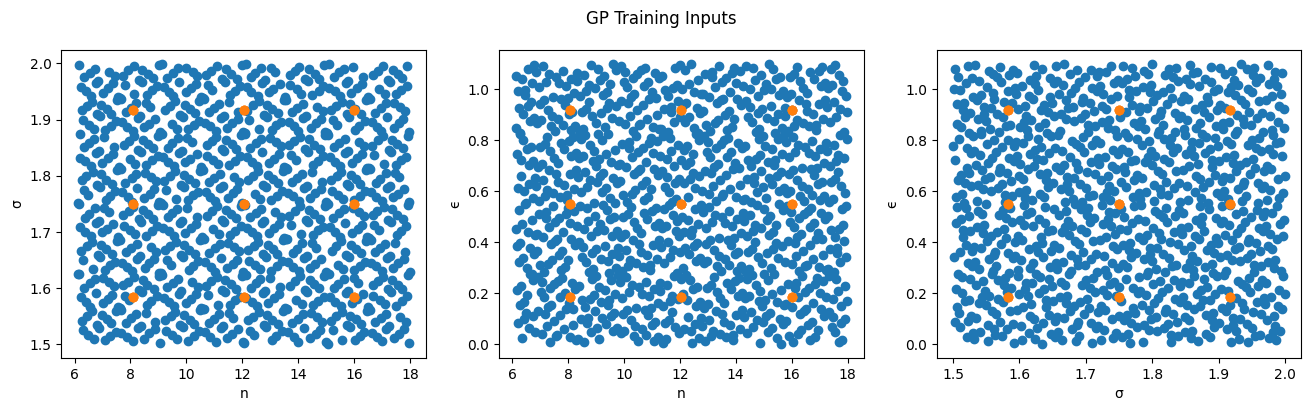

In [3]:
ndims = 3          #number of model parameters
nsims = 960        #number of training simulations

# Rescale ranges
ranges = np.array([[6.1, 18.0],
                   [1.5, 2],
                   [0, 1.1]])
#ranges determined from the Mie fluid phase diagram for kbT = 1 and ρ = 0.1 atom/V
try:
    input_dict = load(open('training_data/training_samples.p', 'rb'))
    xs = input_dict['xs']
    print('load success')
except:

    # Generate samples of the correct dimensions
    xs = sobol((nsims, ndims))
    xs = ranges[:, 0] + xs * (ranges[:, 1] - ranges[:, 0])

    # Save the input samples
    output_dict = dict(xs = xs)
    dump(output_dict, open('training_data/training_samples.p', 'wb'))


num = 3
n_range = np.linspace(ranges[0,0] + (ranges[0,1] - ranges[0,0])/6 ,ranges[0,1] - (ranges[0,1] - ranges[0,0])/6,num)
σ_range = np.linspace(ranges[1,0] + (ranges[1,1] - ranges[1,0])/6 ,ranges[1,1] - (ranges[1,1] - ranges[1,0])/6,num)
ϵ_range = np.linspace(ranges[2,0] + (ranges[2,1] - ranges[2,0])/6 ,ranges[2,1] - (ranges[2,1] - ranges[2,0])/6,num)

exp_params = []

for n in n_range:
    for σ in σ_range:
        for ϵ in ϵ_range:
            exp_params.append([n,σ,ϵ])

exp_params = np.array(exp_params)
print("Number of Experiments:", len(exp_params))

# Visualization
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
plt.suptitle("GP Training Inputs")
axs[0].scatter(xs[:, 0], xs[:, 1],label="Training")
axs[0].scatter(exp_params[:, 0], exp_params[:, 1],label="Insilico Experimental GT")
axs[0].set_xlabel('n')
axs[0].set_ylabel('σ')
axs[1].scatter(xs[:, 0], xs[:, 2],label="Training")
axs[1].scatter(exp_params[:, 0], exp_params[:, 2],label="Insilico Experimental GT")
axs[1].set_xlabel('n')
axs[1].set_ylabel('ϵ')
axs[2].scatter(xs[:, 1], xs[:, 2],label="Training")
axs[2].scatter(exp_params[:, 1], exp_params[:, 2],label="Insilico Experimental GT")
axs[2].set_xlabel('σ')
axs[2].set_ylabel('ϵ')
plt.show()

## Simulation Loop

In [4]:
N_particles = 1_000
name = "A"
timestep = 0.0025 # 48.#### fs
kbT = 1
density = 0.1
eq_time = 50_000
production_time = 5e5
path = "training_data"

In [5]:
# cfg.set({'distributed.scheduler.worker-ttl': None})
# client = Client(n_workers=80)
# client

In [6]:
# # Queue up function calls into dask
# lazy_results = []
# for i in range (len(xs)):
#     lazy_results.append(dask.delayed(mie_fluid)(path, "_train_" + str(i), N_particles, xs[i][1]*2.5, name, timestep, 
#                                                  xs[i][0], xs[i][1], xs[i][2],
#                                                  kbT, density, eq_time, production_time))

# # Allow dask to parallelize the set of simulations and run them
# results = dask.compute(*lazy_results)

In [7]:
 print("Done")

Done


In [8]:
rmax = (0.95/2)*((N_particles/density)**(1/3))
rmin = 0
rnum = 250
r = np.linspace(rmin,rmax,rnum)

#assume atom size of ~2.5 A^-1
qmax = np.pi/(2.5*(rmax - rmin)/rnum) #qmax in reduced space is (π/Δr)*1/2.5
qmin = 1.25                           #qmin in reduced space is qmin for standard diffractometers * 2.5 A
qnum = 236                            #qnum selected so that the spacing is approximately 0.05A^{-1} for a 2.5 A particle
q = np.linspace(qmin,qmax,qnum) 
print('qmin =', qmin)
print('qmax =', qmax)
print('Δq =', q[1]- q[0])

qmin = 1.25
qmax = 30.698908169815425
Δq = 0.12531450285027845


In [9]:
traj = gsd.hoomd.open('training_data/traj/mie_train_' + str(0) + '.gsd', 'r')
box = freud.box.Box.from_box(traj[0].configuration.box[:3])

In [10]:
try: 
    input_dict = load(open('training_data/train_data.p', 'rb'))
    xs = input_dict['xs']
    sqs = input_dict['sqs']
    rdfs = input_dict['rdfs']
    print('load success')

except:
    print('load failed... computing rdfs and sqs')
    rdfs = np.empty((nsims,rnum))

    for i in range(nsims):
        # Create a freud compute object (RDF is the canonical example)
        rdf = freud.density.RDF(bins=rnum, r_min = rmin, r_max=rmax)
        traj = gsd.hoomd.open('training_data/traj/mie_train_' + str(i) + '.gsd', 'r')
        for frame in traj:
            rdf.compute(system=(box,frame.particles.position), reset=False)
        # Get bin centers, RDF data from attributes
        rdfs[i] = rdf.rdf

        if i % 10 == 0:
            print("Completed Itr",i)
            
        sqs = np.empty((nsims,qnum))

    for i in range(nsims):
        sqs[i] = rdf2sq(rdf.bin_centers,rdfs[i],qmin,qmax,qnum,density)[1]

    output_dict = dict(xs = xs, sqs = sqs, rdfs = rdfs)
    dump(output_dict, open('training_data/train_data.p', 'wb'))

load success


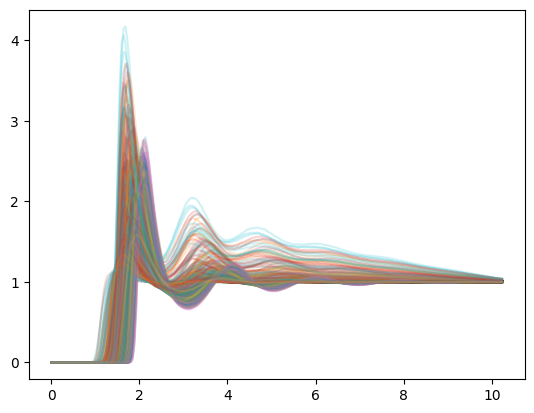

In [11]:
for i in range(nsims):
    plt.plot(r,rdfs[i],alpha=0.2)
plt.show()

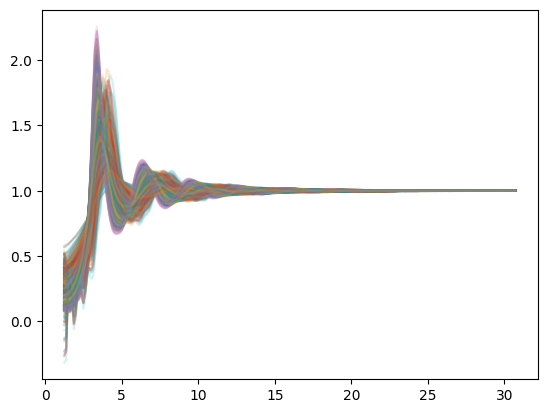

In [12]:
for i in range(nsims):
    plt.plot(q,sqs[i],alpha=0.2)
plt.show()

In [13]:
ndims = 3          #number of model parameters
nsims = 160        #number of testing simulations

try:
    ranges_test = np.array([[6.1 + (18.0-6.1)/8, 18 - (18.0-6.1)/8],
                       [1.5 + (2-1.5)/8, 2 - (2-1.5)/8],
                       [0 + 1.1/8, 1.1 - 1.1/8]])
    input_dict = load(open('testing_data/testing_samples.p', 'rb'))
    xs_test = input_dict['xs_test']
    print('load success')

except:

    ranges_test = np.array([[6.1 + (18.0-6.1)/8, 18 - (18.0-6.1)/8],
                   [1.5 + (2-1.5)/8, 2 - (2-1.5)/8],
                   [0 + 1.1/8, 1.1 - 1.1/8]])
    
    np.random.seed(69420)
    
    print('load fail')
    # Generate samples of the correct dimensions
    xs_test = np.random.uniform(size=(nsims, ndims))
    xs_test = ranges_test[:, 0] + xs_test * (ranges_test[:, 1] - ranges_test[:, 0])

    
    # Save the input samples
    output_dict = dict(xs_test = xs_test)
    dump(output_dict, open('testing_data/testing_samples.p', 'wb'))

load fail


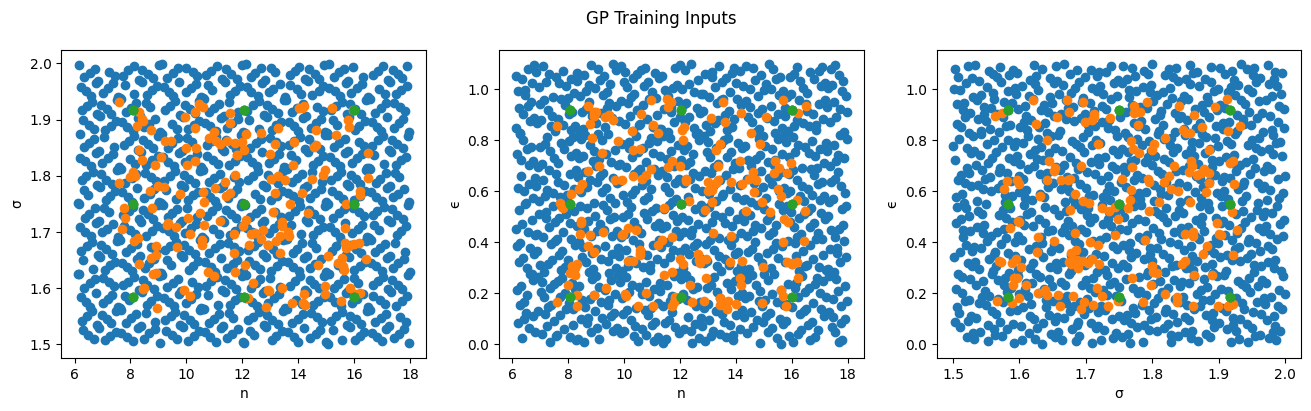

In [14]:
# Visualization
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
plt.suptitle("GP Training Inputs")
axs[0].scatter(xs[:, 0], xs[:, 1],label="Training")
axs[0].scatter(xs_test[:, 0], xs_test[:, 1],label="Testing")
axs[0].scatter(exp_params[:, 0], exp_params[:, 1],label="Insilico Experimental GT")
axs[0].set_xlabel('n')
axs[0].set_ylabel('σ')
axs[1].scatter(xs[:, 0], xs[:, 2],label="Training")
axs[1].scatter(xs_test[:, 0], xs_test[:, 2],label="Testing")
axs[1].scatter(exp_params[:, 0], exp_params[:, 2],label="Insilico Experimental GT")
axs[1].set_xlabel('n')
axs[1].set_ylabel('ϵ')
axs[2].scatter(xs[:, 1], xs[:, 2],label="Training")
axs[2].scatter(xs_test[:, 1], xs_test[:, 2],label="Testing")
axs[2].scatter(exp_params[:, 1], exp_params[:, 2],label="Insilico Experimental GT")
axs[2].set_xlabel('σ')
axs[2].set_ylabel('ϵ')
plt.show()

In [15]:
cfg.set({'distributed.scheduler.worker-ttl': None})
client = Client(n_workers=160)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 160
Total threads: 160,Total memory: 187.40 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41997,Workers: 160
Dashboard: http://127.0.0.1:8787/status,Total threads: 160
Started: Just now,Total memory: 187.40 GiB
Comm: tcp://127.0.0.1:34033,Total threads: 1
Dashboard: http://127.0.0.1:39293/status,Memory: 1.17 GiB
Nanny: tcp://127.0.0.1:36915,


In [17]:
path = "testing_data"

# Queue up function calls into dask
lazy_results = []
for i in range (len(xs_test)):
    lazy_results.append(dask.delayed(mie_fluid)(path, "_test_" + str(i), N_particles, xs_test[i][1]*2.5, name, timestep, 
                                                 xs_test[i][0], xs_test[i][1], xs_test[i][2],
                                                 kbT, density, eq_time, production_time))

# Allow dask to parallelize the set of simulations and run them
results = dask.compute(*lazy_results)

notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice

notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
notice

2024-03-26 16:40:03,672 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 16:40:18,597 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 16:40:31,969 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 16:40:48,148 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 16:41:01,431 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 16:41:12,929 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 16:41:23,756 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 16:41:36,030 - distributed.utils_perf - WARNING - full garbage collections took

2024-03-26 16:53:32,717 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 16:53:45,176 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 16:54:02,199 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 16:54:15,102 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 16:54:36,210 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 16:54:51,208 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 16:55:02,846 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 16:55:15,309 - distributed.utils_perf - WARNING - full garbage collections took

2024-03-26 17:07:39,787 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-03-26 17:07:52,663 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-03-26 17:08:06,506 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-03-26 17:08:17,539 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-03-26 17:08:33,226 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-03-26 17:08:46,860 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-03-26 17:09:09,618 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-03-26 17:09:26,556 - distributed.utils_perf - WARNING - full garbage collections took

2024-03-26 17:20:20,083 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:20:35,140 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:20:44,931 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:20:58,464 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:21:12,878 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:21:28,931 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:21:41,738 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:21:55,643 - distributed.utils_perf - WARNING - full garbage collections took

2024-03-26 17:33:19,515 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:33:30,174 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:33:39,315 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:33:48,274 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:33:59,327 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:34:08,321 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:34:19,558 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:34:31,995 - distributed.utils_perf - WARNING - full garbage collections took

2024-03-26 17:43:00,949 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:43:08,991 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:43:16,930 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:43:24,562 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:43:32,101 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:43:39,157 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:43:46,563 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-03-26 17:43:54,195 - distributed.utils_perf - WARNING - full garbage collections took

2024-03-26 17:51:02,101 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 17:51:10,308 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 17:51:17,010 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 17:51:24,569 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 17:51:32,097 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 17:51:39,820 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 17:51:47,500 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 17:51:55,004 - distributed.utils_perf - WARNING - full garbage collections took

In [18]:
for i in range(nsims):
    # Create a freud compute object (RDF is the canonical example)
    rdf = freud.density.RDF(bins=rnum, r_min = rmin, r_max=rmax)
    traj = gsd.hoomd.open('testing_data/traj/mie_test_' + str(i) + '.gsd', 'r')
    for frame in traj:
        rdf.compute(system=(box,frame.particles.position), reset=False)
    # Get bin centers, RDF data from attributes
    rdfs[i] = rdf.rdf

    if i % 10 == 0:
        print("Completed Itr",i)
        
sqs = np.empty((nsims,qnum))

for i in range(nsims):
    sqs[i] = rdf2sq(rdf.bin_centers,rdfs[i],qmin,qmax,qnum,density)[1]

output_dict = dict(xs_test = xs_test, sqs = sqs, rdfs = rdfs)
dump(output_dict, open('testing_data/test_data.p', 'wb'))

Completed Itr 0
Completed Itr 10


2024-03-26 20:03:46,862 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Completed Itr 20
Completed Itr 30
Completed Itr 40
Completed Itr 50
Completed Itr 60


2024-03-26 20:04:52,285 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Completed Itr 70
Completed Itr 80
Completed Itr 90
Completed Itr 100
Completed Itr 110
Completed Itr 120


2024-03-26 20:06:03,426 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Completed Itr 130
Completed Itr 140
Completed Itr 150


2024-03-26 20:06:53,094 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 20:07:00,589 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 20:07:08,594 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 20:07:16,015 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 20:07:24,101 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 20:07:32,011 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 20:07:40,444 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-03-26 20:07:48,535 - distributed.utils_perf - WARNING - full garbage collections took